In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import OrthogonalMatchingPursuit
from sklearn.linear_model import OrthogonalMatchingPursuitCV
from sklearn.datasets import make_sparse_coded_signal

from scipy.cluster.hierarchy import fcluster, linkage
from scipy.spatial.distance import squareform
import matplotlib.pyplot as plt
from scipy.spatial import distance

from ibmdata.plot.wafermap import wafermap, wafermap_gallery, WafermapConfig
import matplotlib as mpl

Discreet Cosine Transform

$$x = 1,2,....P \quad y = 1,2,....Q \quad in\ cartesian\ domain$$
$$u = 1,2,....P \quad v = 1,2,....Q \quad in\ frequency\ domain$$

$$A_{u,v}(x,y) = \alpha_u\beta_v\cos{\frac{\pi(2x-1)(u-1)}{2P}}\cos{\frac{\pi(2y-1)(v-1)}{2Q}}$$

$$\alpha_u =\begin{cases}
            \sqrt{\frac{1}{P}} & (u=1) \\
            \sqrt{\frac{2}{P}} & (2 \leq u \leq P)
            \end{cases}
  \qquad
  \beta_v = \begin{cases}
            \sqrt{\frac{1}{Q}} & (v=1) \\
            \sqrt{\frac{2}{Q}} & (2 \leq v \leq Q)
            \end{cases}
$$

For P10 DD2, P = 1:11 Q = 1:10

For zA DD2, P = 1:11 Q = 1:11

In [2]:
def DCT(P,Q,x,y,ignore=[]):
    A = []
    for u in range(1,P+1):
        for v in range(1,Q+1):
            if u == 1:
                alpha = np.sqrt(1/P)
            else:
                alpha = np.sqrt(2/P)
            if v == 1:
                beta = np.sqrt(1/Q)
            else:
                beta = np.sqrt(2/Q)
            transform = alpha*beta*np.cos((np.pi*(2*x-1)*(u-1))/(2*P))*np.cos((np.pi*(2*y-1)*(v-1))/(2*Q))
            if (u,v) in ignore:
                transform = 0
            A.append(transform)
    return np.array(A)
                
def pullxy(df,x,y,minusone=True):
    return df[[x,y]].apply(lambda x: x-1).values.tolist()

def fillA(xy,prod):
    A = []
    P10ignore = [(1,1),(1,2),(1,3),(2,1),(3,1),(4,1),(2,2),(8,1),(9,1),(10,1),(11,1),
                 (10,2),(11,2),(11,3),(11,4),(11,7),(11,8),(10,9),(11,9),(8,10),(9,10),
                 (10,10),(11,10),(1,8),(1,9),(2,9),(1,10),(2,10),(3,10),(4,10)]
    zAignore = [(1,1),(1,2),(1,3),(1,4),(2,1),(3,1),(4,1),(2,2),(8,1),(9,1),(10,1),(11,1),
                (10,2),(11,2),(11,3),(11,4),(11,8),(11,9),(10,10),(11,10),(8,11),(9,11),
                (10,11),(1,8),(1,9),(1,10),(2,10),(1,11),(2,11),(3,11),(4,11)]
    if prod == 'p10dd2':
        P,Q = 11,10
        ignore = P10ignore
    elif prod == 'zadd2':
        P,Q = 11,11
        ignore = zAignore
    for x,y in xy:
        A.append(DCT(P,Q,x,y,ignore))
    return np.array(A)

def translate_idx_to_uv(idx, Q):
    x = idx//Q + 1
    #y = Q - (idx%Q + 1) + 1
    y = idx%Q + 1
    return (x,y)

def parseData(df, groupby = 'wafer_id', b_input = None, x = 'unitcell_x', y = 'unitcell_y', family_code = 'p10dd2'):
    wafers = df[groupby].unique()
    B = []
    Alpha = []
    for waferid in wafers:
        cur_df = df[df[groupby]== waferid]
        b = np.array(cur_df[b_input])
        xy = pullxy(cur_df,x,y)
        A = fillA(xy,family_code)
        B.append(b)
        Alpha.append(A)
    return wafers, B, Alpha

def createEuclidianDistanceMatrix(etas):
    output = []
    for a in etas:
        row = []
        for b in etas:
            row.append(distance.euclidean(a,b))
        output.append(row)
    return output

In [3]:
import ibmdata
from scipy import interpolate
#pulldf = pd.read_csv("p10_za_wft_sram_dbc_fails.csv")
pulldf = pd.read_csv("zA_all_shdwcac_fails_wftcoord.csv")
pulldf['chip_cnt'] = 1
pulldf['waf_chip_cnt'] = pulldf.groupby('wafer_id').chip_cnt.transform('sum')
#schema = 'p10dd2'
schema = 'zadd2'
#failcol = 'dbccount'
failcol = 'fails'
interpolate_wmap = True
pulldf = pulldf[pulldf.schema == schema]

if interpolate_wmap:
    filldfs = []
    for geo, geodf in pulldf.groupby(['schema']):
        print(geodf[['geographykey']].iloc[0][0])
        schema_geodf = ibmdata.isdw.geography.get_geography( geokey=geodf[['geographykey']].iloc[0][0])
        schema_geodf = schema_geodf[schema_geodf.devloc.eq(0) & schema_geodf.unitcell_x.ne(0)]
        #display(schema_geodf)
        wafx = 'unitcell_x'
        wafy = 'unitcell_y'
        wafx_cols = schema_geodf[wafx].unique()
        wafx_cols.sort()
        wafy_cols = schema_geodf[wafy].unique()
        wafy_cols.sort()
        for wafer, waferdf in geodf.groupby(['wafer_id']):
            tempdf = pd.merge(schema_geodf[[wafx,wafy]], waferdf[[wafx,wafy,failcol]], how="left", on=[wafx,wafy], suffixes=["","_drop"])
            missingcnt = tempdf[failcol].isnull().sum()
            pivotdf = pd.pivot_table(tempdf, values=failcol, index=[wafy], columns=[wafx], dropna=False).reset_index()
            pivotdf = pivotdf.drop(columns=[wafy])
            array = pivotdf.to_numpy()

            #mask invalid values
            array = np.ma.masked_invalid(array)
            xx, yy = np.meshgrid(wafx_cols, wafy_cols)
            #get only the valid values
            x1 = xx[~array.mask]
            y1 = yy[~array.mask]
            newarr = array[~array.mask]

            #method = ['linear', 'nearest', 'cubic']
            GD1 = interpolate.griddata((x1, y1), newarr.ravel(), (xx, yy), method='nearest')

            newdf = pd.DataFrame(GD1, columns = wafx_cols, index = wafy_cols).reset_index()
            newdf = newdf.rename(columns = {'index':wafy})
            newXdf = pd.melt(newdf, id_vars=[wafy], value_vars=wafx_cols, var_name=wafx, value_name=failcol)
            newXdf = pd.merge(schema_geodf, newXdf[[wafx,wafy,failcol]], how="left", on=[wafx,wafy], suffixes=["","_drop"])
            newXdf['wafer_id'] = wafer
            newXdf['missing_cnt'] = missingcnt
            filldfs.append(newXdf)
    df = pd.concat(filldfs)
else:
    df = pulldf.copy()

66809515


In [4]:
wafers, B, Alpha = parseData(df, groupby = 'wafer_id', b_input =failcol, x = 'unitcell_x', y = 'unitcell_y', family_code = schema)

In [5]:
etas = []
nonzero_indices = []
for i in range(len(wafers)):
    omp = OrthogonalMatchingPursuit(n_nonzero_coefs=15, normalize=False)
    omp.fit(Alpha[i], B[i])
    coef = omp.coef_
    (idx_r,) = coef.nonzero()
    etas.append(coef)
    nonzero_indices.append(idx_r)

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_omp.py:419: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  out = _cholesky_omp(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_omp.py:419: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  out = _cholesky_omp(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_omp.py:419: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  out = _cholesky_omp(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_omp.py:419: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  out = _cholesky_o

In [6]:
DistMatrix = createEuclidianDistanceMatrix(etas)
dists = squareform(DistMatrix)
linkage_matrix = linkage(dists, "complete")

In [7]:
#results = fcluster(linkage_matrix, t=300, criterion='distance')
results = fcluster(linkage_matrix, t=5, criterion='maxclust')

In [8]:
results

array([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 3, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 3, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,

In [9]:
from collections import defaultdict
clusters = defaultdict(list)
for i, c in enumerate(results):
    clusters[c].append(wafers[i])

In [10]:
resultsdf = pd.DataFrame(data={'wafer_id':wafers, 'result':results})
resultsdf['wafer_cnt'] = resultsdf.groupby('result').wafer_id.transform('count')
classifieddf = pd.merge(df, resultsdf, on=['wafer_id'], how='left')
print(len(classifieddf['wafer_id'].unique()))
print(len(classifieddf['result'].unique()))
display(classifieddf)

729
5


,geographykey,rlse_step_pn,rlse_step_ec,normalized_testx,normalized_testy,kerf_x,kerf_y,device_exposure_x,device_exposure_y,area_center_5,...,unitcell_y,x_center_ply_logical,y_center_ply_logical,devloc_name,exclusion,fails,wafer_id,missing_cnt,result,wafer_cnt
0,66810167,0000003JM477,10000P22636,46,103,42,104,42,104,A,...,9,0.0,0.0,zArtemis,4500.0,0.0,A290V-01,30,5,720
1,66810387,0000003JM477,10000P22636,54,129,50,130,50,130,C,...,11,0.0,0.0,zArtemis,4500.0,0.0,A290V-01,30,5,720
2,66809891,0000003JM477,10000P22636,38,25,34,26,34,26,C,...,3,0.0,0.0,zArtemis,4500.0,0.0,A290V-01,30,5,720
3,66809875,0000003JM477,10000P22636,38,12,34,13,34,13,D,...,2,0.0,0.0,zArtemis,4500.0,0.0,A290V-01,30,5,720
4,66809398,0000003JM477,10000P22636,6,90,2,91,2,91,D,...,8,0.0,0.0,zArtemis,4500.0,0.0,A290V-01,30,5,720
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64876,66810323,0000003JM477,10000P22636,54,77,50,78,50,78,A,...,7,0.0,0.0,zArtemis,4500.0,0.0,AZD38-25,24,5,720
64877,66809483,0000003JM477,10000P22636,14,77,10,78,10,78,C,...,7,0.0,0.0,zArtemis,4500.0,0.0,AZD38-25,24,5,720
64878,66810119,0000003JM477,10000P22636,46,64,42,65,42,65,A,...,6,0.0,0.0,zArtemis,4500.0,0.0,AZD38-25,24,5,720
64879,66810915,0000003JM477,10000P22636,86,77,82,78,82,78,D,...,7,0.0,0.0,zArtemis,4500.0,0.0,AZD38-25,24,5,720


[<AxesSubplot:title={'center':'1-1'}>,
 <AxesSubplot:title={'center':'2-1'}>,
 <AxesSubplot:title={'center':'3-3'}>,
 <AxesSubplot:title={'center':'4-4'}>,
 <AxesSubplot:title={'center':'5-720'}>]

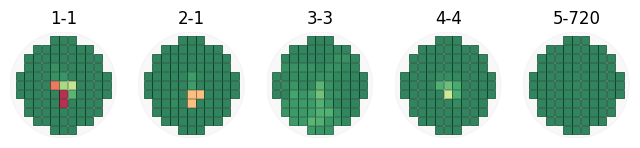

In [11]:
#import random
#plotdf = df[df['wafer_id'].isin(random.choices(clusters[43],k=5))]
#,wafer_cnt=('wafer_id',pd.Series.nunique)
plotdf = classifieddf.groupby(['normalized_testx','normalized_testy','geographykey','result','wafer_cnt']).agg({failcol:'mean'}).reset_index()
plotdf['result'] = plotdf['result'].astype(str) + '-' + plotdf['wafer_cnt'].astype(str)
#plotdf['result'] = plotdf['result'].astype(object)


width = 800
height = 500
columns = 5

display(
    wafermap_gallery(
        WafermapConfig(
            plotdf, 
            chipx_column='normalized_testx', 
            chipy_column='normalized_testy', 
            color_by_column=failcol, 
            colormap = mpl.cm.RdYlGn.reversed(),
            #discrete=True, 
            title=f"wafermaps",
            #plot_type='plotly',
            plot_type='mpl',
            width=width,
            height=height,
            show_kerf_borders=False
        ), 
        wafer_column='result',
        columns = columns
    )
)

Index(['wafer_id', 'result', 'missing_cnt', 'fail_mean', 'fail_max', 'delta'], dtype='object')
['AZCZV-22', 'AZCZV-22', 'AZCZV-22', 'AZCZV-22', 'AZCZV-22', 'AZCZV-22', 'AZCZZ-10', 'AZCZZ-10', 'AZCZZ-10', 'AZCZZ-10', 'AZCZZ-10', 'AZCZZ-10', 'A290X-20', 'A290X-08', 'A290X-08', 'AZD0A-08', 'A290X-08', 'A290X-20', 'A290X-08', 'A290X-20', 'AZCZV-24', 'AZCZZ-11', 'A290X-13', 'AZCZV-24', 'A290X-13', 'AZCZV-24', 'AZCZV-24', 'AZCZZ-11', 'A290V-01', 'AZCZZ-25', 'AZD06-12', 'A29WA-21', 'AZD0Y-23', 'AZD2Z-08', 'AZD0T-15', 'AZCZZ-15']


/var/folders/56/cfmz315s09g6zv7qvb074jgm0000gn/T/ipykernel_8412/3507314264.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sampledf['result'] = sampledf['result'].astype(object)


,geographykey,rlse_step_pn,rlse_step_ec,normalized_testx,normalized_testy,kerf_x,kerf_y,device_exposure_x,device_exposure_y,area_center_5,...,unitcell_y,x_center_ply_logical,y_center_ply_logical,devloc_name,exclusion,fails,wafer_id,missing_cnt,result,wafer_cnt
0,66810167,0000003JM477,10000P22636,46,103,42,104,42,104,A,...,9,0.0,0.0,zArtemis,4500.0,0.0,A290V-01,30,5,720
1,66810387,0000003JM477,10000P22636,54,129,50,130,50,130,C,...,11,0.0,0.0,zArtemis,4500.0,0.0,A290V-01,30,5,720
2,66809891,0000003JM477,10000P22636,38,25,34,26,34,26,C,...,3,0.0,0.0,zArtemis,4500.0,0.0,A290V-01,30,5,720
3,66809875,0000003JM477,10000P22636,38,12,34,13,34,13,D,...,2,0.0,0.0,zArtemis,4500.0,0.0,A290V-01,30,5,720
4,66809398,0000003JM477,10000P22636,6,90,2,91,2,91,D,...,8,0.0,0.0,zArtemis,4500.0,0.0,A290V-01,30,5,720
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60159,66810323,0000003JM477,10000P22636,54,77,50,78,50,78,A,...,7,0.0,0.0,zArtemis,4500.0,25.0,AZD2Z-08,82,5,720
60160,66809483,0000003JM477,10000P22636,14,77,10,78,10,78,C,...,7,0.0,0.0,zArtemis,4500.0,0.0,AZD2Z-08,82,5,720
60161,66810119,0000003JM477,10000P22636,46,64,42,65,42,65,A,...,6,0.0,0.0,zArtemis,4500.0,25.0,AZD2Z-08,82,5,720
60162,66810915,0000003JM477,10000P22636,86,77,82,78,82,78,D,...,7,0.0,0.0,zArtemis,4500.0,25.0,AZD2Z-08,82,5,720


[<AxesSubplot:title={'center':'AZCZV-22'}>]

[<AxesSubplot:title={'center':'AZCZZ-10'}>]

[<AxesSubplot:title={'center':'A290X-08'}>,
 <AxesSubplot:title={'center':'A290X-20'}>,
 <AxesSubplot:title={'center':'AZD0A-08'}>]

[<AxesSubplot:title={'center':'A290X-13'}>,
 <AxesSubplot:title={'center':'AZCZV-24'}>,
 <AxesSubplot:title={'center':'AZCZZ-11'}>]

[<AxesSubplot:title={'center':'A290V-01'}>,
 <AxesSubplot:title={'center':'A29WA-21'}>,
 <AxesSubplot:title={'center':'AZCZZ-15'}>,
 <AxesSubplot:title={'center':'AZCZZ-25'}>,
 <AxesSubplot:title={'center':'AZD06-12'}>,
 <AxesSubplot:title={'center':'AZD0T-15'}>,
 <AxesSubplot:title={'center':'AZD0Y-23'}>,
 <AxesSubplot:title={'center':'AZD2Z-08'}>]

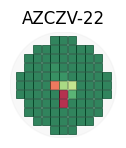

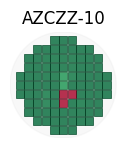

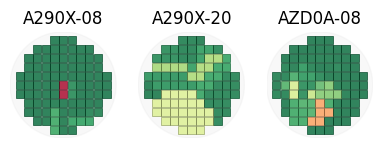

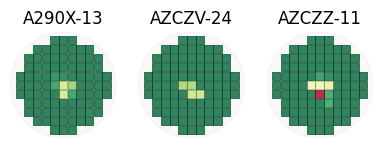

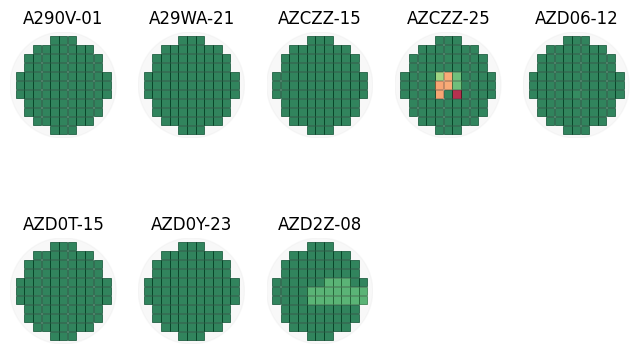

In [12]:

if interpolate_wmap:
    wafsumdf = classifieddf.groupby(['wafer_id','result']).agg(missing_cnt=('missing_cnt','mean'), fail_mean=(failcol,'mean'), fail_max=(failcol,'max')).reset_index()
else:
    wafsumdf = classifieddf.groupby(['wafer_id','result']).agg(fail_mean=(failcol,'mean'), fail_max=(failcol,'max')).reset_index()
wafsumdf['delta'] = wafsumdf['fail_max'] - wafsumdf['fail_mean']
print(wafsumdf.columns)

sample_wafers = []
for res, resdf in wafsumdf.groupby(['result']):
    resdf.sort_values(['delta'], inplace=True)
    sample_wafers.extend(resdf['wafer_id'].head(1))
    sample_wafers.extend(resdf['wafer_id'].tail(1))
    sample_wafers.extend(resdf['wafer_id'].sample(min(len(resdf),2)))
    if interpolate:
        resdf.sort_values(['missing_cnt'], inplace=True)
        sample_wafers.extend(resdf['wafer_id'].head(1))
        sample_wafers.extend(resdf['wafer_id'].tail(1))
        sample_wafers.extend(resdf['wafer_id'].sample(min(len(resdf),2)))
    else:
        sample_wafers.extend(resdf['wafer_id'].sample(min(len(resdf),4)))
    
print(sample_wafers)

sampledf = classifieddf[classifieddf['wafer_id'].isin(sample_wafers)]
sampledf['result'] = sampledf['result'].astype(object)
display(sampledf)

width = 800
height = 500
columns = 5

for res, resdf in sampledf.groupby(['result']):
    display(
        wafermap_gallery(
            WafermapConfig(
                resdf, 
                chipx_column='normalized_testx', 
                chipy_column='normalized_testy', 
                color_by_column=failcol, 
                colormap = mpl.cm.RdYlGn.reversed(),
                #discrete=True, 
                title=f"wafermaps - {res}",
                #plot_type='plotly',
                plot_type='mpl',
                width=width,
                height=height,
                show_kerf_borders=False
            ), 
            wafer_column='wafer_id',
            columns = columns
        )
    )